## Calculating time averages

Let's say we want to average the monthly time series data from the previous exercise into annually averaged data.

There are a number of ways to do this.  Probably the easiest in this case, since we know the data is monthly, would be to chunk through every 12 data points.  Looking at the dates, we see that the data starts in January.  So, if we loop every 12 points, and take the average of those, we should be able to get an annual average for each year.

In [22]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

nc_cmi = xr.open_dataset('Champaign_data.nc')
nc_cmi


<xray.Dataset>
Dimensions:      (lat: 1, lon: 1, nv: 2, time: 1628)
Coordinates:
  * lat          (lat) float32 41.0
  * lon          (lon) float32 -89.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 1880-03-15 ...
  * nv           (nv) int64 0 1
Data variables:
    time_bnds    (time, nv) int32 29219 29250 29250 29279 29279 29310 29310 ...
    tempanomaly  (time, lat, lon) float64 7.94 3.23 0.04 0.07 2.96 0.62 ...
Attributes:
    title: GISTEMP Surface Temperature Analysis
    institution: NASA Goddard Institute for Space Studies
    source: http://data.giss.nasa.gov/gistemp/
    Conventions: CF-1.6
    history: Created 2015-09-11 09:23:38 by SBBX_to_nc 2.0 - ILAND=1200, IOCEAN=NCDC/ER4, Base: 1951-1980

Let's calculate how many years of data we have.

$$\text{number of years} = \frac{\text{number of months}}{12} $$

In [23]:
# How many years do we have?

ntimes=np.shape(nc_cmi['time'])
print(ntimes[0]/12.)

135.666666667


OK, we don't have an even number of months going into years.  The data starts in January 1880, so it must go partially into a year.  Let's forget about the last partial year, and do the averages starting in January 1880 through the end.  We can calculate the number of years to calculate by using `numpy`'s floor command (rounding down to the nearest integer after dividing by 12.  We will then create `numpy` array of averages, `nyears` long, that will store the data, and the dates.

In [5]:
nyears=np.floor(ntimes[0]/12)
nyears

135.0

Now, we need to devise an *algorithm* to average the monthly data by year.  This can be accomplished by indexing the data to include every 12 months in a list, and subsetting the array.  It can be helpful to think about this as a numberline problem.  In the diagram below, the `-`'s are each month in the dataset (12 per year), and we want to average over each year in the dataset, from 1880-2014.



Thinking about how to go about this, we know that we need to pick the first 12 months of the data to get the 1880 data.  This can be accomplished by using indexing of the data and time.  Let's try to find the first year, keeping in mind that the first element (January 1880) is index 0, and the last index will not be included (convention of python).

In [7]:
data_1880=nc_cmi['tempanomaly'][0:12]
time_1880=nc_cmi['time'][0:12]
#let's check the time to see if it worked
print time_1880
print(data_1880)

<xray.DataArray 'time' (time: 12)>
array(['1880-01-15T00:00:00.000000000Z', '1880-02-15T00:00:00.000000000Z',
       '1880-03-15T00:00:00.000000000Z', '1880-04-15T00:00:00.000000000Z',
       '1880-05-15T00:00:00.000000000Z', '1880-06-15T00:00:00.000000000Z',
       '1880-07-15T00:00:00.000000000Z', '1880-08-15T00:00:00.000000000Z',
       '1880-09-15T00:00:00.000000000Z', '1880-10-15T00:00:00.000000000Z',
       '1880-11-15T00:00:00.000000000Z', '1880-12-15T00:00:00.000000000Z'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 1880-03-15 ...
Attributes:
    long_name: time
    bounds: time_bnds
<xray.DataArray 'tempanomaly' (time: 12, lat: 1, lon: 1)>
array([[[ 7.93999982]],

       [[ 3.22999993]],

       [[ 0.04      ]],

       [[ 0.07      ]],

       [[ 2.95999993]],

       [[ 0.61999999]],

       [[-0.50999999]],

       [[ 0.        ]],

       [[-1.08999998]],

       [[-1.74999996]],

       [[-5.30999988]],

       [[-3.529999

OK, we found the first year.  Now we need to figure out how to get the subsequent years, automatically.  Let's try 1881:

In [8]:
data_1881=nc_cmi['tempanomaly'][12:24]
time_1881=nc_cmi['time'][12:24]
#let's check the time to see if it worked
print time_1881

<xray.DataArray 'time' (time: 12)>
array(['1881-01-15T00:00:00.000000000Z', '1881-02-15T00:00:00.000000000Z',
       '1881-03-15T00:00:00.000000000Z', '1881-04-15T00:00:00.000000000Z',
       '1881-05-15T00:00:00.000000000Z', '1881-06-15T00:00:00.000000000Z',
       '1881-07-15T00:00:00.000000000Z', '1881-08-15T00:00:00.000000000Z',
       '1881-09-15T00:00:00.000000000Z', '1881-10-15T00:00:00.000000000Z',
       '1881-11-15T00:00:00.000000000Z', '1881-12-15T00:00:00.000000000Z'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1881-01-15 1881-02-15 1881-03-15 ...
Attributes:
    long_name: time
    bounds: time_bnds


Now we need to automate this - we don't want to do this for all the months in the file!  Time for a for loop.  We can loop over each year by using `nyears` that we calculated above.  Now we need to map from the counter that will go from 0:nyears to the months.  From the above, we want to have the first element be the January of each year, and the last December, keeping in mind how python indexing works.  We can multiply the counter by 12, then add one to the counter and multiply it by 12 to get the right data.

In [9]:
for i in np.arange(nyears):
    print(i,nc_cmi['time'][i*12:((i+1)*12)],nc_cmi['tempanomaly'][i*12:((i+1)*12)])

(0.0, <xray.DataArray 'time' (time: 12)>
array(['1880-01-15T00:00:00.000000000Z', '1880-02-15T00:00:00.000000000Z',
       '1880-03-15T00:00:00.000000000Z', '1880-04-15T00:00:00.000000000Z',
       '1880-05-15T00:00:00.000000000Z', '1880-06-15T00:00:00.000000000Z',
       '1880-07-15T00:00:00.000000000Z', '1880-08-15T00:00:00.000000000Z',
       '1880-09-15T00:00:00.000000000Z', '1880-10-15T00:00:00.000000000Z',
       '1880-11-15T00:00:00.000000000Z', '1880-12-15T00:00:00.000000000Z'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 1880-03-15 ...
Attributes:
    long_name: time
    bounds: time_bnds, <xray.DataArray 'tempanomaly' (time: 12, lat: 1, lon: 1)>
array([[[ 7.93999982]],

       [[ 3.22999993]],

       [[ 0.04      ]],

       [[ 0.07      ]],

       [[ 2.95999993]],

       [[ 0.61999999]],

       [[-0.50999999]],

       [[ 0.        ]],

       [[-1.08999998]],

       [[-1.74999996]],

       [[-5.30999988]],

       [[-3

Perfect.  Now we just need to calculate the average temperature anomaly in each of those ranges:

In [10]:
for i in np.arange(nyears):
    print(i,nc_cmi['time'][i*12],np.mean(nc_cmi['tempanomaly'][i*12:((i+1)*12)]))

(0.0, <xray.DataArray 'time' ()>
numpy.datetime64('1880-01-15T00:00:00.000000000Z')
Coordinates:
    time     datetime64[ns] 1880-01-15
Attributes:
    long_name: time
    bounds: time_bnds, <xray.DataArray 'tempanomaly' ()>
array(0.22249999502673745))
(1.0, <xray.DataArray 'time' ()>
numpy.datetime64('1881-01-15T00:00:00.000000000Z')
Coordinates:
    time     datetime64[ns] 1881-01-15
Attributes:
    long_name: time
    bounds: time_bnds, <xray.DataArray 'tempanomaly' ()>
array(0.30166665992389124))
(2.0, <xray.DataArray 'time' ()>
numpy.datetime64('1882-01-15T00:00:00.000000000Z')
Coordinates:
    time     datetime64[ns] 1882-01-15
Attributes:
    long_name: time
    bounds: time_bnds, <xray.DataArray 'tempanomaly' ()>
array(0.23499999474734068))
(3.0, <xray.DataArray 'time' ()>
numpy.datetime64('1883-01-15T00:00:00.000000000Z')
Coordinates:
    time     datetime64[ns] 1883-01-15
Attributes:
    long_name: time
    bounds: time_bnds, <xray.DataArray 'tempanomaly' ()>
array(-1.2783333

Let's create a `numpy` array to store the data in, as well as the times, being careful of the data type:

In [12]:
tempanom_annual=np.zeros(int(nyears))
times_annual=np.zeros(int(nyears),dtype="datetime64")

Let's roll:  (note: we'll just pick the first month of the year as the time)

[ 0.2225      0.30166666  0.23499999 -1.2783333  -0.57249999 -1.6733333
 -0.78833332 -0.39416666 -1.19999997 -0.03666667  0.27333333  0.08833333
 -0.59333332 -0.84833331  0.67083332 -0.58999999  0.38583332  0.13166666
  0.28916666 -0.08        0.67416665 -0.06166667 -0.035      -0.44499999
 -1.03749998 -0.44666666  0.2025     -0.39833332  0.63749999 -0.03916667
  0.03583333  0.81916665 -0.87666665  0.70416665  0.17666666 -0.09833333
 -0.20583333 -1.58999996  0.1725      0.39583332 -0.27916666  1.85749996
  0.83166665  0.18416666 -1.03083331  0.28249999 -0.44999999  0.34999999
  0.06333333 -0.62666665  0.61583332  1.86666662  0.41916666  1.10416664
  0.87583331  0.0475      0.11833333 -0.17666666  1.29999997  1.05249998
 -0.50916666  1.02583331  0.28083333 -0.12083333  0.53749999 -0.1225
  1.12916664  0.04333333  0.23749999  0.82499998 -0.66499999 -0.52083332
  0.67749998  1.21999997  1.00166664  0.54166665  0.43916666  0.27333333
 -0.53249999  0.22916666 -0.45416666 -0.07666666 -0.22  

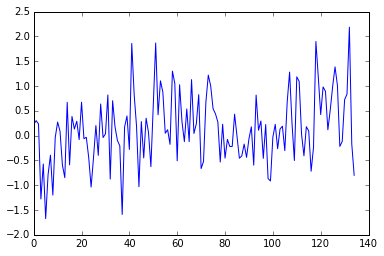

In [15]:
for i in np.arange(int(nyears)):
    tempanom_annual[i]=nc_cmi['tempanomaly'][i*12:((i+1)*12)].mean(dim='time')
#    times_annual[i]=nc_cmi['time'][i*12]

print(tempanom_annual)

plt.plot(tempanom_annual)

`xray` has built in functionality for this, to make it really easy!  Some examples:

http://xray.readthedocs.org/en/stable/time-series.html

http://xray.readthedocs.org/en/stable/examples/weather-data.html#toy-weather-data


In [18]:
nc_cmi_ann=nc_cmi.resample('12MS', dim='time', how='mean')

In [19]:
print(nc_cmi_ann)

<xray.Dataset>
Dimensions:      (lat: 1, lon: 1, nv: 2, time: 136)
Coordinates:
  * lat          (lat) float32 41.0
  * lon          (lon) float32 -89.0
  * nv           (nv) int64 0 1
  * time         (time) datetime64[ns] 1880-01-01 1881-01-01 1882-01-01 ...
Data variables:
    time_bnds    (time, nv) float64 2.939e+04 2.942e+04 2.975e+04 2.978e+04 ...
    tempanomaly  (time, lat, lon) float64 0.2225 0.3017 0.235 -1.278 -0.5725 ...


Write the data file out, easy!!

In [20]:
nc_cmi_ann.to_netcdf('nc_cmi_ann.nc')

Plot the original and annually-averaged time series.

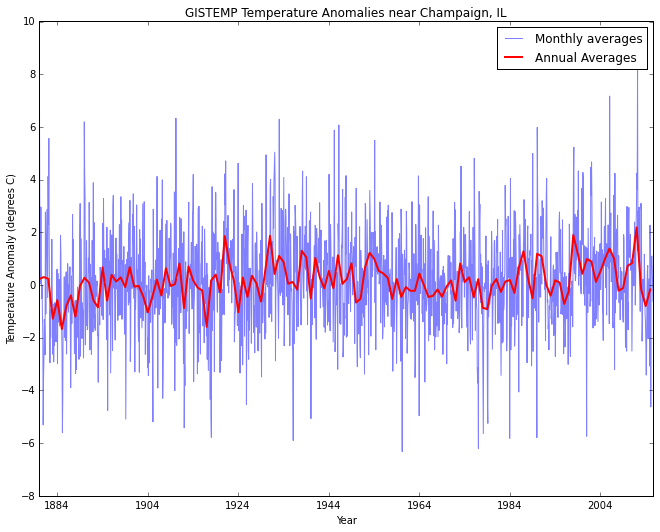

In [21]:
plt.figure(figsize=(11,8.5)) #create a new figure

plt.plot(nc_cmi['time'],np.squeeze(nc_cmi['tempanomaly']),'b',alpha=0.5)
plt.plot(nc_cmi_ann['time'],np.squeeze(nc_cmi_ann['tempanomaly']),'r',linewidth=2.0)
plt.legend(['Monthly averages','Annual Averages'])
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (degrees C)')
plt.title('GISTEMP Temperature Anomalies near Champaign, IL')
plt.show()
